In [2]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
sys.path.append("../../../python")

import matplotlib.pyplot as plt
import numpy as np
import scipy
import tqdm

from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
reload(parser)
reload(datatypes)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

Welcome to JupyROOT 6.28/10


## Commands

We first do a single run and check the distribution of generated particles 

```bash
# Make a new folder to save data for this test
data_dir=~/data/simulation/temp/musim_test/cosmic
# data_dir=~/data/simulation/temp/musim_test/cosmic
mkdir -p $data_dir
data_dir=`realpath $data_dir`
run=2

./_start_single_run.sh ~/geant_projects/mathusla-newsim $data_dir 8000000 $run

# We run the tracker again to save all events, becasue the default setting in the above script only save events with upward vertex.
pushd ../../../build
# ./digitizer $data_dir/run_${run}.root -s 1 -p 10000 -n 24
./tracker $data_dir/run_${run}_digi.root -r $data_dir/run_${run}.root -k 3 -p 10000  
popd

```

Then we test scripts for a series of run, and for multiple series

```bash
# Run simulation + digitization + reconstruction
./_start_series_of_run.sh \
    -p `realpath ../../..` \
    -m $data_dir \
    -e 100000 \
    -r 3 \
    -s 3 \
    -c y

bash _submit_series.sh -f cosmic_p/_start_series_of_run.sh \
    -m $data_dir \
    -e 100000 \
    -r 4 \
    -j 2 \
    -t 1 \
    -n cosmic_p
    -s Run    
```

In [9]:
data_dir="../../../../musim_test/cosmic"
fname_recon = f"{data_dir}/run_2_digi_recon.root"

In [10]:
f1 = root.tfile_reader(fname_recon)
f1.ls()
# f1.ls_tree()

## Get metadata
f1.get_tree("metadata;2")
metadata_digi = f1.get_entry(0)

f1.get_tree("metadata;3")
metadata_sim = f1.get_entry(0)

f1.get_tree("data")
# f1.ls_tree()
f1.get_entry(0);
print("Total entries:", f1.entries)

None
Total entries: 267938
TFile**		../../../../musim_test/cosmic/run_2_digi_recon.root	
 TFile*		../../../../musim_test/cosmic/run_2_digi_recon.root	
  KEY: TTree	data;10	Reconstruction Tree [current cycle]
  KEY: TTree	data;9	Reconstruction Tree [backup cycle]
  KEY: TTree	metadata;3	Simulation metadata [current cycle]
  KEY: TTree	metadata;2	Metadata for digitization [backup cycle]
  KEY: TTree	metadata;1	Metadata for reconstruction [backup cycle]


In [19]:
print(metadata_sim)
## We can see the Real time simulated is 11.7314 seconds. The simulation took 300 seconds to run on my computer, cedar is 3 times slower.

# Traslate this to flux
flux = 1000000/6000**2/11.7314
print("Flux [/cm2/s]", flux)

{'SimulationName': 'Mathusla simulation\n', 'Geometry': 'mu40v0\n', 'Generator': 'cry\n', 'Time': '2025-02-12 17:31:23\n', 'GenReserved1': 'Real time simulated:11.7314', 'GenReserved2': '\x00', 'GenReserved3': '\x00', 'GenReserved4': '\x00'}
Flux [/cm2/s] 0.002367814393659561


In [86]:
data = f1.get_entry(0)
print(data.keys())

dict_keys(['SimEntry', 'Track_x0', 'Track_y0', 'Track_z0', 'Track_t0', 'Track_kx', 'Track_ky', 'Track_kz', 'Track_kt', 'Track_cov', 'Track_chi2', 'Track_id', 'Track_iv_ind', 'Track_iv_err', 'Track_digiInds', 'Vertex_x0', 'Vertex_y0', 'Vertex_z0', 'Vertex_t0', 'Vertex_cov', 'Vertex_chi2', 'Vertex_id', 'Vertex_trackInds', 'Vertex_tracklet_n0', 'Vertex_tracklet_n2', 'Vertex_tracklet_n3', 'Vertex_tracklet_n4p', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_t', 'Digi_edep', 'Digi_trackID', 'Digi_pdgID', 'Digi_detectorID', 'Digi_type', 'Digi_hitInds', 'Digi_direction', 'Run_number', 'Evt_number', 'Seed_0', 'Seed_1', 'Gen_x', 'Gen_y', 'Gen_z', 'Gen_t', 'Gen_px', 'Gen_py', 'Gen_pz', 'Gen_pdgID', 'Gen_index'])


In [11]:
keys = ["digi_x", "digi_y", "digi_z", "digi_layer", "gen_x", "gen_y", "gen_z", "gen_px", "gen_py", "gen_pz", "residual_x", "residual_y", "residual_z", "residual_t", "direction", "det_id", "hit_x", "hit_y", "hit_z"] 
res = {key:[] for key in keys}

def process_digi(data):
    data["Digi_hitInds_split"] = parser.unpack_at(data["Digi_hitInds"], -1)

isbreak=False
for i in tqdm.tqdm(range(f1.entries)):
    data_digi = data_raw = f1.get_entry(i)
    process_digi(data_digi)


    for j in range(len(data_digi["Digi_x"])):
        raw_ind = data_digi["Digi_hitInds_split"][j][0]
        if raw_ind==9999999:
            continue        
        res["digi_x"].append(data_digi["Digi_x"][j])
        res["digi_y"].append(data_digi["Digi_y"][j])
        res["digi_z"].append(data_digi["Digi_z"][j])  
        res["hit_x"].append(data_raw["Hit_x"][raw_ind])
        res["hit_y"].append(data_raw["Hit_y"][raw_ind])
        res["hit_z"].append(data_raw["Hit_z"][raw_ind])          
        res["residual_x"].append(data_digi["Digi_x"][j] - data_raw["Hit_x"][raw_ind])
        res["residual_y"].append(data_digi["Digi_y"][j] - data_raw["Hit_y"][raw_ind])
        res["residual_z"].append(data_digi["Digi_z"][j] - data_raw["Hit_z"][raw_ind])
        res["residual_t"].append(data_digi["Digi_t"][j] - data_raw["Hit_t"][raw_ind])
        res["direction"].append(data_digi["Digi_direction"][j])
        res["det_id"].append(data_digi["Digi_detectorID"][j])
        if abs(res["residual_y"][-1])>100 and res["direction"][-1]==12:
            for raw_ind in data_digi["Digi_hitInds_split"][j]:
                # print(data_digi["Digi_y"][j], data_raw["Hit_y"][raw_ind], data_raw["Hit_x"][raw_ind], data_digi["Digi_detectorID"][j], data_raw["Hit_detectorID"][raw_ind])
                print(data_digi["Digi_z"][j], data_raw["Hit_y"][raw_ind], data_raw["Hit_x"][raw_ind], data_raw["Hit_z"][raw_ind],data_digi["Digi_detectorID"][j])

            print(i)
            isbreak=True
            # break

    for j in range(len(data_digi["Gen_x"])):
        res["gen_x"].append(data_digi["Gen_x"][j])
        res["gen_y"].append(data_digi["Gen_y"][j])
        res["gen_z"].append(data_digi["Gen_z"][j])  
        res["gen_px"].append(data_digi["Gen_px"][j])
        res["gen_py"].append(data_digi["Gen_py"][j])
        res["gen_pz"].append(data_digi["Gen_pz"][j])  

    digi_layerid = (np.array(data_digi["Digi_detectorID"])//1e5)%1000
    digi_detid = (np.array(data_digi["Digi_detectorID"])//1e11)%1000
    res["digi_layer"].extend(list(digi_layerid + digi_detid*6))

for key in res:
    res[key] = np.array(res[key])

100%|█████████████████████████████████████████████████████████████████████████| 267938/267938 [01:28<00:00, 3043.00it/s]


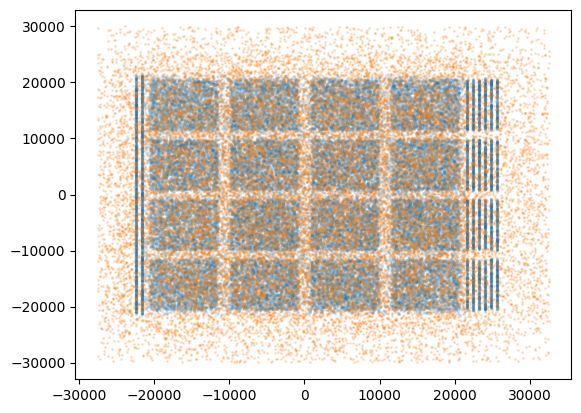

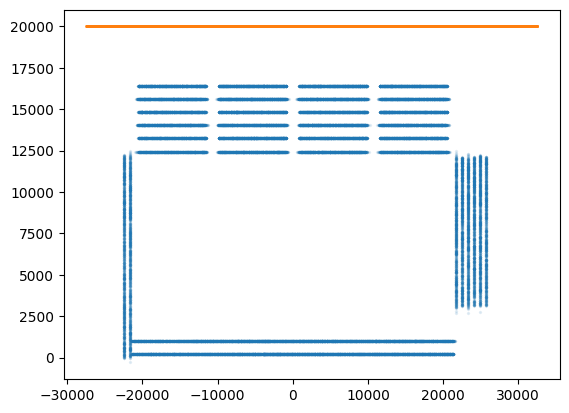

In [12]:
plt.scatter(res["digi_x"][::5], res["digi_y"][::5], s=2, alpha=0.1)
plt.scatter(res["gen_x"][::10], res["gen_y"][::10], s=1, alpha=0.2)
plt.show()

plt.scatter(res["digi_x"][::5], res["digi_z"][::5], s=2, alpha=0.1)
plt.scatter(res["gen_x"][::10], res["gen_z"][::10], s=1, alpha=0.2)
plt.show()

In [3]:
gen_pvec = [res["gen_px"],res["gen_py"],res["gen_pz"]]
gen_pnorm = np.linalg.norm(gen_pvec, axis=0)

plt.hist(gen_pnorm*1e-3,bins=100);
plt.yscale("log")
plt.xlabel("Momentum [GeV/c]")

NameError: name 'res' is not defined

In [30]:
data_dir="../../../../musim_test/"
fname_comb = f"{data_dir}/series_2_digi_recon.root"

# data_dir="/home/tomren/data/simulation/temp/musim_test/cosmic"
# fname_comb = f"{data_dir}/run_2_digi_recon.root"



f2 = root.tfile_reader(fname_comb)
## Get metadata
# f2.get_tree("metadata;2")
# metadata_digi = f2.get_entry(0)

f2.ls()
f2.get_tree("data")
print("Entries", f2.entries)

None
Entries 424
TFile**		../../../../musim_test//series_2_digi_recon.root	
 TFile*		../../../../musim_test//series_2_digi_recon.root	
  KEY: TTree	metadata;3	Simulation metadata [current cycle]
  KEY: TTree	metadata;2	Metadata for digitization [backup cycle]
  KEY: TTree	metadata;1	Metadata for reconstruction [backup cycle]
  KEY: TTree	data;1	Reconstruction Tree


In [48]:
d = f2.get_entry(9)

In [49]:
len(d["Track_x0"])

16

217


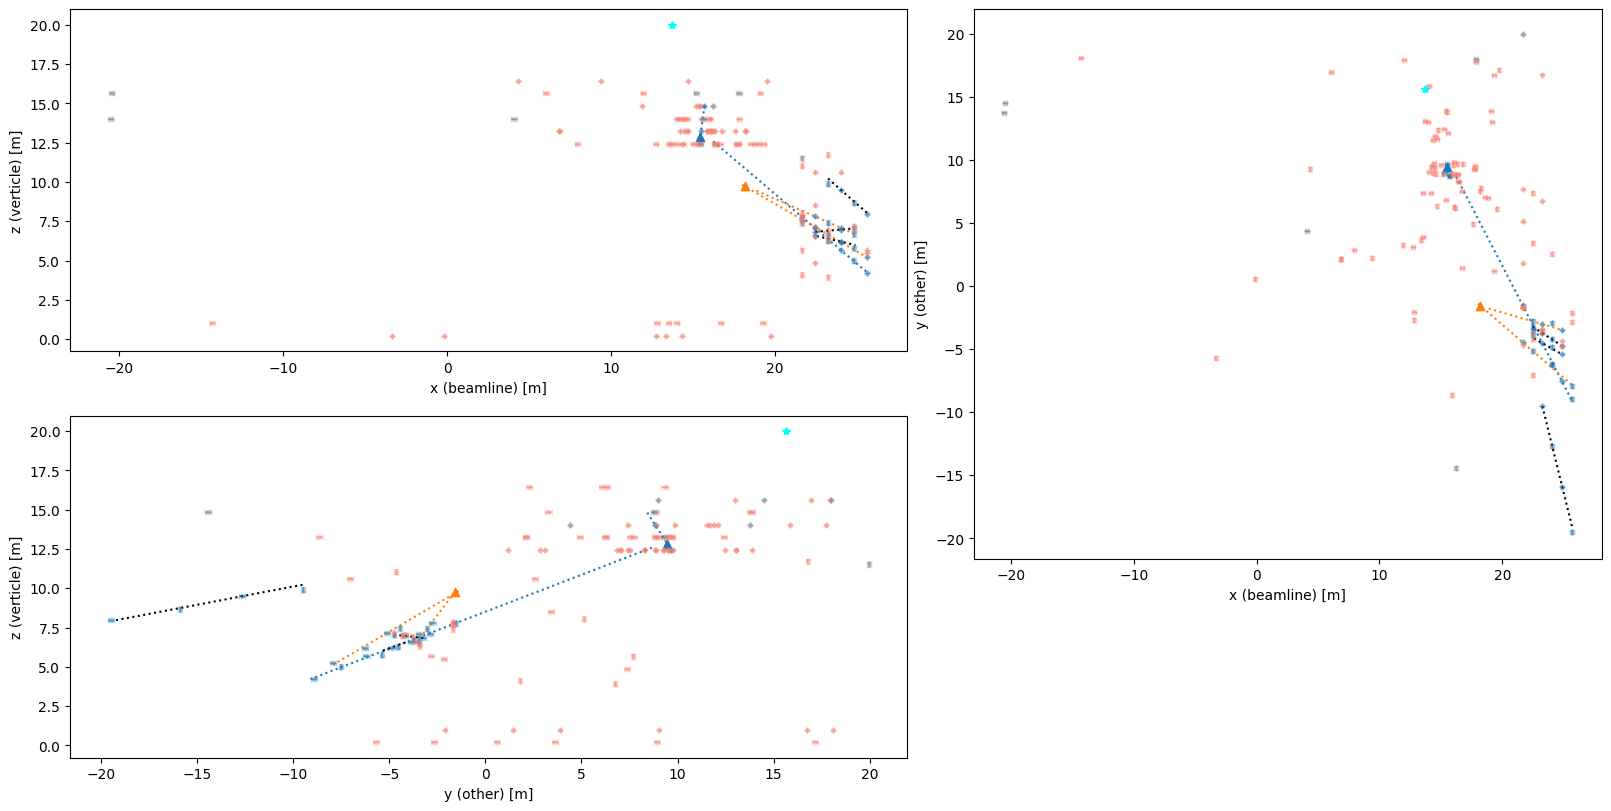

In [65]:
i=217
# i+=1
print(i)

data = f2.get_entry(i)
event = datatypes.Event(data, metadata_digi)  
event.plot()

In [ ]:
./skim /home/tomren/data/simulation/temp/musim_test/cosmic/run_2_digi_recon.root